In [ ]:
# Cell 1: Install Libraries and Apply Optimizations
# This cell installs necessary libraries and patches scikit-learn for GPU/CPU optimizations.

# Install core libraries (quietly to reduce output)
%pip install --quiet numpy scipy matplotlib seaborn scikit-learn xgboost joblib

# Install RAPIDS cuML for GPU acceleration of scikit-learn models
%pip install --quiet cuml-cu12 --extra-index-url https://pypi.nvidia.com/
%pip install --quiet cugraph-cu12 --extra-index-url https://pypi.nvidia.com/
%pip install --quiet cudf-cu12 --extra-index-url https://pypi.nvidia.com/

#  Appling Optimizations for Scikit-learn (MKL) 
try:
    from sklearnex import patch_sklearn
    patch_sklearn()
    print("Scikit-learn optimizations (Intel® oneAPI Data Analytics Library) applied.")
except ImportError:
    print("scikit-learn-intelex not found or patch failed. Random Forest and SVM might be slower.")
    print("If running on CPU, consider: %pip install scikit-learn-intelex")

#  CRITICAL: Load cuML acceleration for Scikit-learn 
# This command tells scikit-learn to use cuML's GPU-accelerated versions
# where available. This is how Random Forest and SVM will use the GPU.
try:
    %load_ext cuml.accel
    print("cuML acceleration for scikit-learn loaded.")
except Exception as e:
    print(f"Could not load cuML acceleration: {e}. Random Forest and SVM will run on CPU.")
    print("Ensure RAPIDS cuML is correctly installed for your Colab CUDA version.")


# --- Core Imports ---
import os
import numpy as np
import scipy.io
import gc # For garbage collection

# Check for torch (used for CUDA availability check for XGBoost)
try:
    import torch
    print(f"PyTorch available (version: {torch.__version__}, CUDA available: {torch.cuda.is_available()})")
except ImportError:
    print("PyTorch not found. Skipping CUDA availability check for XGBoost (will use CPU).")

# --- ML Imports (should be after patch_sklearn() and %load_ext cuml.accel) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Traditional ML Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

import joblib # For saving/loading models

print("\nAll libraries imported and initial setup complete.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.0 MB/s eta 0:00:00
scikit-learn-intelex not found or patch failed. Random Forest and SVM might be slower.
If running on CPU, consider: %pip install scikit-learn-intelex
cuML: Accelerator installed.
cuML acceleration for scikit-learn loaded.
PyTorch available (version: 2.6.0+cu124, CUDA available: True)

All libraries imported and initial setup complete.


In [ ]:
# Cell 2: Mount Google Drive & Copy Dataset to Local Colab Storage
# This ensures fast access to your dataset during processing.

from google.colab import drive
import shutil

drive.mount('/content/drive')

# Define paths
drive_dataset_path = "/content/drive/MyDrive/dataset" # This expects 'archive' to be directly inside 'dataset'
local_dataset_path = "/content/dataset"


if not os.path.exists(local_dataset_path):
    print(f"Copying dataset from Google Drive ({drive_dataset_path}) to local Colab storage ({local_dataset_path})... This may take a few minutes for 5GB.")
    try:
        shutil.copytree(drive_dataset_path, local_dataset_path)
        print("Dataset copied successfully to Colab local directory.")
    except Exception as e:
        print(f"ERROR: Could not copy dataset. Please check if '{drive_dataset_path}' exists in your Google Drive.")
        print(f"Error details: {e}")
        # Fallback: if copy fails, try to use drive path directly (slower)
        DATASET_PATH = drive_dataset_path
        print(f"Attempting to use Google Drive path directly: {DATASET_PATH} (may be slower).")
else:
    print("Dataset already exists in Colab local storage.")

# Set path for later use (default to local Colab path)
DATASET_PATH = local_dataset_path

print(f"Using dataset path: {DATASET_PATH}")
if not os.path.exists(DATASET_PATH):
    print(f"CRITICAL ERROR: The specified dataset path '{DATASET_PATH}' does not exist. Please fix this before proceeding.")
else:
    print("Dataset path confirmed to exist.")

Mounted at /content/drive
Copying dataset from Google Drive (/content/drive/MyDrive/dataset) to local Colab storage (/content/dataset)... This may take a few minutes for 5GB.
Dataset copied successfully to Colab local directory.
Using dataset path: /content/dataset
Dataset path confirmed to exist.


In [ ]:
# Cell 3: Utility Functions
def extract_sys_dia(abp_signal):
    """Extracts systolic and diastolic BP from an ABP signal."""
    systolic = np.max(abp_signal)
    diastolic = np.min(abp_signal)
    return np.array([systolic, diastolic]) # Ensure numpy array for consistency

def get_mat_file_paths(dataset_path):
    """Returns a list of full paths to .mat files in the dataset directory."""
    mat_files = []
    # Adjust for your structure: if 'archive' is inside 'dataset', then need to join that.
    # Assuming DATASET_PATH points to the 'dataset' folder, and 'archive' is inside it.
    archive_path = os.path.join(dataset_path, 'archive') # Adjust if 'archive' is not present or named differently

    if not os.path.exists(archive_path):
        print(f"Warning: 'archive' folder not found at {archive_path}. Checking direct dataset_path.")
        # Fallback to direct path if 'archive' subfolder not found
        search_path = dataset_path
    else:
        search_path = archive_path

    for file in sorted(os.listdir(search_path)):
        if file.endswith(".mat"):
            mat_files.append(os.path.join(search_path, file))
    return mat_files

def show_insights_traditional(model_name, y_true, y_pred):
    print(f"\n {model_name} - Final Evaluation Metrics:")
    mae = mean_absolute_error(y_true, y_pred)
    # FIX: Calculate RMSE by taking the square root of MSE to avoid 'squared' parameter error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # Removed squared=False
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Prediction vs Ground Truth (Systolic & Diastolic)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.3, s=10)
    plt.plot([60, 180], [60, 180], '--', color='gray')
    plt.xlabel("True Systolic BP")
    plt.ylabel("Predicted Systolic BP")
    plt.title(f"{model_name} - Systolic BP")
    plt.grid(True)
    plt.axis('equal') # Equalize axes for better visual comparison

    plt.subplot(1, 2, 2)
    plt.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.3, s=10)
    plt.plot([30, 100], [30, 100], '--', color='gray') # Adjust range for diastolic
    plt.xlabel("True Diastolic BP")
    plt.ylabel("Predicted Diastolic BP")
    plt.title(f"{model_name} - Diastolic BP")
    plt.grid(True)
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

In [ ]:
# Cell 4:  Data Loading 

def load_and_segment_subset_data(file_paths, seq_len, num_files_to_load=None):
    all_ppg_segments = []
    all_abp_targets = []
    processed_count = 0

    files_to_process = file_paths
    if num_files_to_load is not None and len(file_paths) > num_files_to_load:
        files_to_process = file_paths[:num_files_to_load]
        print(f"Loading and segmenting data from a subset of {len(files_to_process)} out of {len(file_paths)} files...")
    else:
        print(f"Loading and segmenting data from all {len(file_paths)} files...")

    for i, file_path in enumerate(files_to_process):
        if (i + 1) % 1 == 0: # Print progress for every file now due to small subset
            print(f"  Processing file {i+1}/{len(files_to_process)}: {os.path.basename(file_path)}")
        try:
            mat = scipy.io.loadmat(file_path)
            records = mat['p'][0]

            for rec_idx, rec in enumerate(records):
                signals = rec
                if signals.shape[0] != 3: continue # Ensure 3 signals (PPG, ABP, ECG)

                ppg_raw = signals[0]
                abp_raw = signals[1]
                target = extract_sys_dia(abp_raw)

                if len(ppg_raw) < seq_len:
                    continue

                for j in range(0, len(ppg_raw) - seq_len + 1, seq_len):
                    segment = ppg_raw[j:j+seq_len]
                    all_ppg_segments.append(segment)
                    all_abp_targets.append(target)
                    processed_count += 1

            del mat, records # Clear memory after processing each file
            gc.collect()

        except Exception as e:
            print(f"Error loading or processing file {file_path}: {e}")
            print("Skipping this file.")

    X = np.array(all_ppg_segments, dtype=np.float32)
    y = np.array(all_abp_targets, dtype=np.float32)

    print(f"Finished loading. Total segments extracted: {processed_count}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# Define seq_len globally
seq_len = 256

# Get all file paths first
mat_file_paths = get_mat_file_paths(DATASET_PATH)
print(f"Found {len(mat_file_paths)} .mat files in total.")

# --- CRITICAL FOR SPEED: Load only a very small subset of files ---
# For training, use the first 2 files.
# For validation, use the next 1 file.
# This will make the data loading and training much faster for demonstration.
num_train_files_for_demo = 2
num_val_files_for_demo = 1

if len(mat_file_paths) < (num_train_files_for_demo + num_val_files_for_demo):
    print(f"ERROR: Not enough .mat files found ({len(mat_file_paths)}) for the demo subsetting.")
    print(f"Need at least {num_train_files_for_demo + num_val_files_for_demo} files.")
    # Fallback: if not enough files, just use all available for train/test split (will be slower if many files)
    train_file_paths, val_file_paths = train_test_split(
        mat_file_paths, test_size=0.2, random_state=42, shuffle=True
    )
    print(f"Falling back to using all available files for train/val split: Train {len(train_file_paths)}, Val {len(val_file_paths)}")
else:
    train_file_paths = mat_file_paths[:num_train_files_for_demo]
    val_file_paths = mat_file_paths[num_train_files_for_demo : num_train_files_for_demo + num_val_files_for_demo]
    print(f"Using subset: Train files {len(train_file_paths)}, Validation files {len(val_file_paths)}")

# Load and segment data for training and validation using the subset
print("\n--- Loading Training Data (Subset) ---")
X_train_raw, y_train = load_and_segment_subset_data(train_file_paths, seq_len)

print("\n--- Loading Validation Data (Subset) ---")
X_val_raw, y_val = load_and_segment_subset_data(val_file_paths, seq_len)

# Data Scaling (StandardScaler)
print("\n--- Scaling Data ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
print("Data scaling complete.")

# Clean up raw data to free memory
del X_train_raw, X_val_raw
gc.collect()

Found 12 .mat files in total.
Using subset: Train files 2, Validation files 1

--- Loading Training Data (Subset) ---
Loading and segmenting data from all 2 files...
  Processing file 1/2: part_1.mat
  Processing file 2/2: part_10.mat
Finished loading. Total segments extracted: 240087
X shape: (240087, 256), y shape: (240087, 2)

--- Loading Validation Data (Subset) ---
Loading and segmenting data from all 1 files...
  Processing file 1/1: part_11.mat
Finished loading. Total segments extracted: 117137
X shape: (117137, 256), y shape: (117137, 2)

--- Scaling Data ---
Data scaling complete.


0


--- Training Random Forest Regressor ---

--- Evaluating Random Forest Regressor ---

 Random Forest - Final Evaluation Metrics:
MAE: 14.7105, RMSE: 19.9376


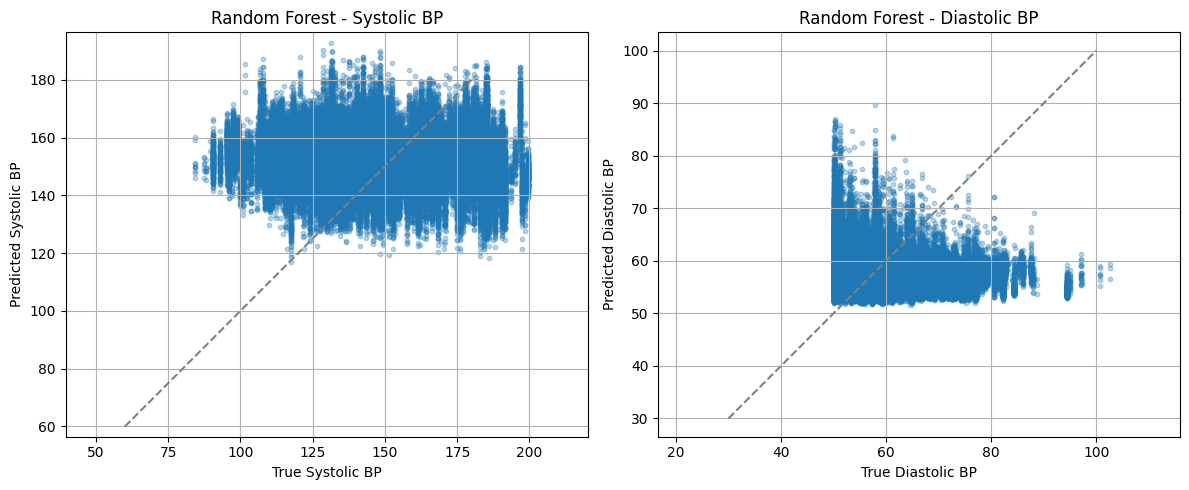

Random Forest model saved.


6931

In [ ]:
# Cell 5: Train & Evaluate Random Forest Regressor (GPU Accelerated via cuML)

from sklearn.multioutput import MultiOutputRegressor # Ensure this is imported (it should be from Cell 1)

print("\n--- Training Random Forest Regressor ---")
# n_estimators: Drastically reduced to 20 for quick demo. Increase for better performance.
# verbose=1: Shows progress.

# 1. Create the base Random Forest Regressor
# cuML handles its parallelism internally on the GPU.
base_rf_model = RandomForestRegressor(n_estimators=20, random_state=42, verbose=1)

# 2. Wrap it with MultiOutputRegressor to handle multiple output targets (Systolic and Diastolic)
# Keep n_jobs=-1 on MultiOutputRegressor to parallelize the training of the two internal models (systolic and diastolic).
# Each of these internal models will then utilize the GPU for its calculations.
rf_model = MultiOutputRegressor(base_rf_model, n_jobs=-1)

# Now fit the MultiOutputRegressor
rf_model.fit(X_train_scaled, y_train)

print("\n--- Evaluating Random Forest Regressor ---")
y_pred_rf = rf_model.predict(X_val_scaled)
show_insights_traditional("Random Forest", y_val, y_pred_rf)

joblib.dump(rf_model, 'random_forest_model.joblib')
print("Random Forest model saved.")

# Clear memory
del rf_model, y_pred_rf, base_rf_model # Also delete base_rf_model
gc.collect()


--- Training XGBoost Regressor ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:20:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)



--- Evaluating XGBoost Regressor ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:20:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [18:20:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



 XGBoost - Final Evaluation Metrics:
MAE: 14.4892, RMSE: 19.5224


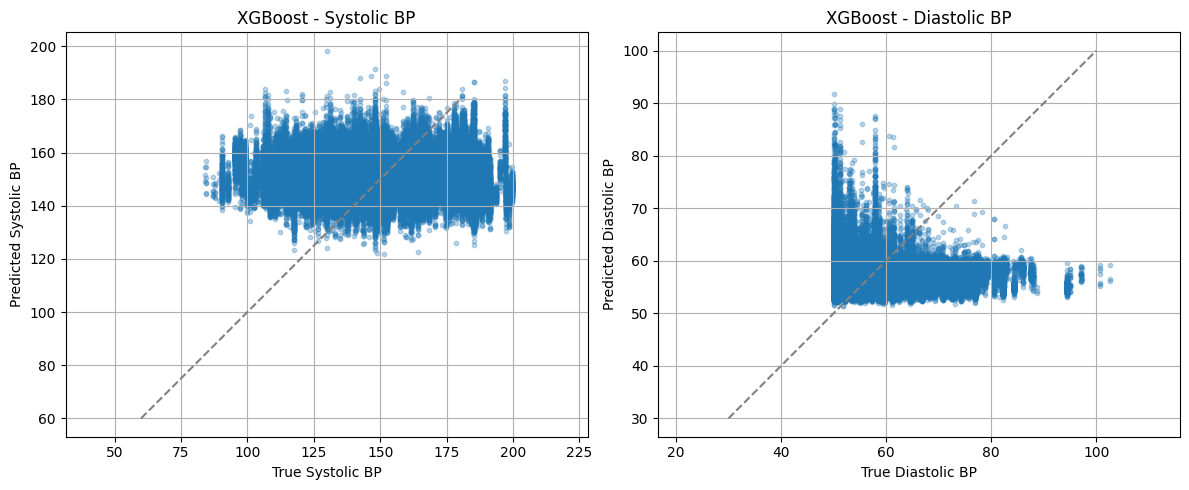

XGBoost model saved.


7128

In [ ]:
# Cell 6: Train & Evaluate XGBoost Regressor (GPU Accelerated)

print("\n--- Training XGBoost Regressor ---")
# n_estimators: Drastically reduced to 20 for quick demo.
# tree_method='gpu_hist' for GPU acceleration.
# device='cuda' explicitly tells it to use the GPU.
# n_jobs is less critical here as GPU handles parallelism, but can keep -1.
xgb_model = XGBRegressor(
    n_estimators=20,
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist', # Force GPU histogram method
    device='cuda' # Explicitly use CUDA device
)
xgb_model.fit(X_train_scaled, y_train)

print("\n--- Evaluating XGBoost Regressor ---")
y_pred_xgb = xgb_model.predict(X_val_scaled)
show_insights_traditional("XGBoost", y_val, y_pred_xgb)

joblib.dump(xgb_model, 'xgboost_model.joblib')
print("XGBoost model saved.")

# Clear memory
del xgb_model, y_pred_xgb
gc.collect()


--- Training SVM Regressor (LinearSVR with MultiOutputRegressor) ---
Using a subset of 20000 samples for SVM training (out of 240087 total).
Using a subset of 5000 samples for SVM evaluation (out of 117137 total).

--- Evaluating SVM Regressor ---

 SVM (LinearSVR) - Final Evaluation Metrics:
MAE: 19.2558, RMSE: 25.7985


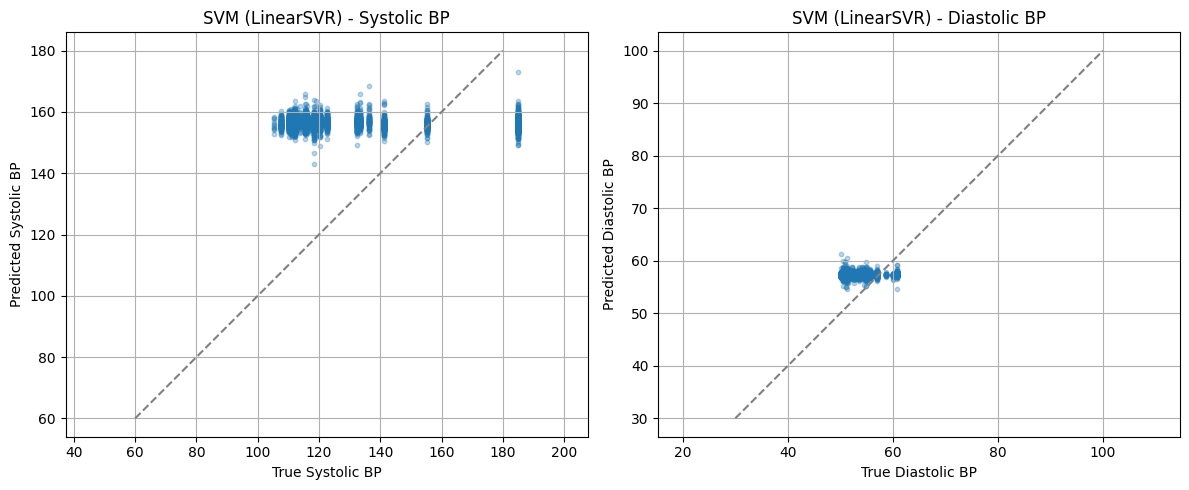

SVM (LinearSVR) model saved.


7202

In [ ]:
# Cell 7: Train & Evaluate SVM Regressor (LinearSVR, GPU Accelerated via cuML)

print("\n--- Training SVM Regressor (LinearSVR with MultiOutputRegressor) ---")

# --- OPTIMIZATION FOR SPEED: Use a smaller subset of the already loaded data for SVM ---
# SVMs (even LinearSVR) can be significantly slower than tree-based models on large datasets.
#reduced the number of samples for THIS MODEL ONLY to ensure it runs quickly for demo purposes.
subset_size_train_svm = 20000
subset_size_val_svm = 5000

# Create the subsets for SVM training
if X_train_scaled.shape[0] > subset_size_train_svm:
    X_train_svm = X_train_scaled[:subset_size_train_svm]
    y_train_svm = y_train[:subset_size_train_svm]
    print(f"Using a subset of {X_train_svm.shape[0]} samples for SVM training (out of {X_train_scaled.shape[0]} total).")
else:
    X_train_svm = X_train_scaled
    y_train_svm = y_train
    print("Using all available training samples for SVM (less than subset_size_train_svm).")

# Create the subsets for SVM validation
if X_val_scaled.shape[0] > subset_size_val_svm:
    X_val_svm = X_val_scaled[:subset_size_val_svm]
    y_val_svm = y_val[:subset_size_val_svm]
    print(f"Using a subset of {X_val_svm.shape[0]} samples for SVM evaluation (out of {X_val_scaled.shape[0]} total).")
else:
    X_val_svm = X_val_scaled
    y_val_svm = y_val
    print("Using all available validation samples for SVM (less than subset_size_val_svm).")


# LinearSVR is used for speed. C=1.0 is a reasonable default.
# cuML will accelerate this if %load_ext cuml.accel worked.
svm_base_model = SVR(kernel='linear', C=1.0, epsilon=0.1)
multi_output_svm_model = MultiOutputRegressor(svm_base_model, n_jobs=-1) # n_jobs here parallelizes the two SVRs

# Fit the MultiOutputRegressor with the smaller subsets
multi_output_svm_model.fit(X_train_svm, y_train_svm)

print("\n--- Evaluating SVM Regressor ---")
# Predict with the smaller validation subset
y_pred_svm = multi_output_svm_model.predict(X_val_svm)
# Pass the subsetted y_val_svm to the insights function
show_insights_traditional("SVM (LinearSVR)", y_val_svm, y_pred_svm)

joblib.dump(multi_output_svm_model, 'svm_linear_model.joblib')
print("SVM (LinearSVR) model saved.")

# Clear memory for the subsetted variables as well
del multi_output_svm_model, y_pred_svm, svm_base_model
del X_train_svm, y_train_svm, X_val_svm, y_val_svm
gc.collect()


--- Training Linear Regression Baseline ---


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:216: UserWarning: Changing solver to 'svd' as this is the only solver that support multiple targets currently.
  ret = func(*args, **kwargs)



 Linear Regression - Final Evaluation Metrics:
MAE: 14.3244, RMSE: 19.2613


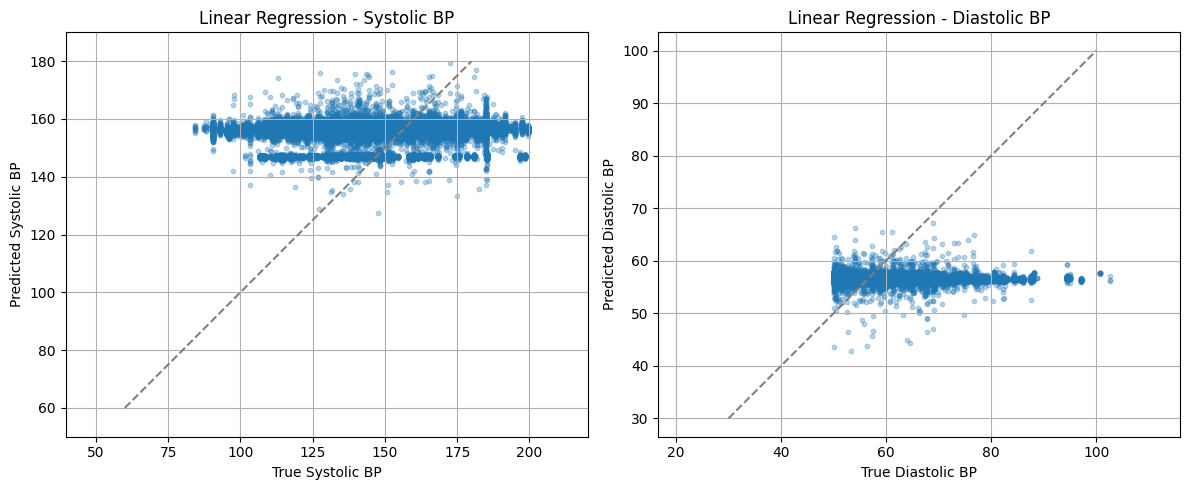


--- Training Ridge Regression Baseline ---

 Ridge Regression - Final Evaluation Metrics:
MAE: 14.3330, RMSE: 19.2766


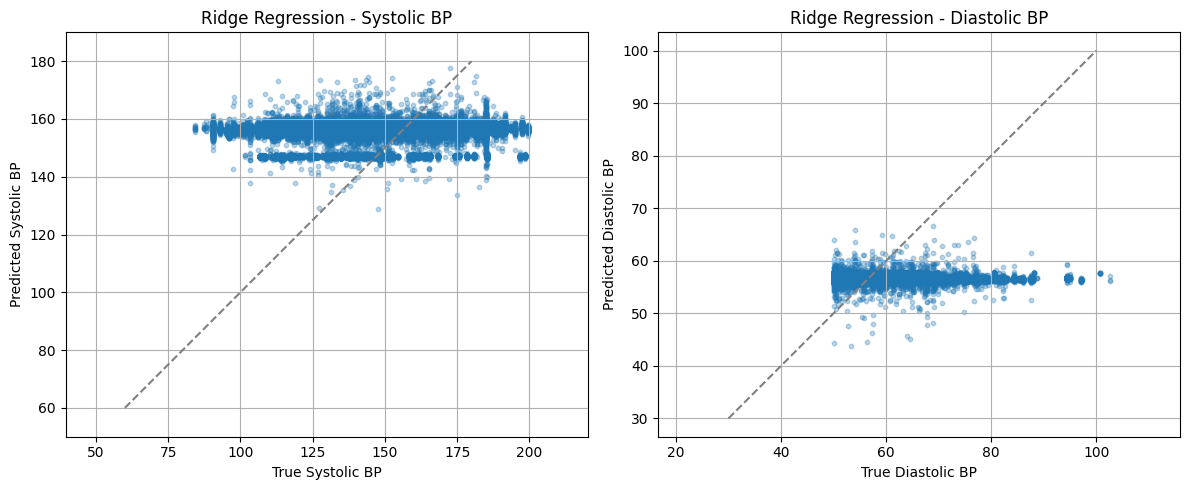

7021

In [ ]:
# Cell 8: Quick Baselines (Linear & Ridge Regression)

print("\n--- Training Linear Regression Baseline ---")
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_val_scaled)
show_insights_traditional("Linear Regression", y_val, y_pred_lr)
del lr_model, y_pred_lr
gc.collect()


print("\n--- Training Ridge Regression Baseline ---")
ridge_model = Ridge(alpha=1.0, random_state=42) # Alpha is regularization strength
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_val_scaled)
show_insights_traditional("Ridge Regression", y_val, y_pred_ridge)
del ridge_model, y_pred_ridge
gc.collect()

In [ ]:
# In[9]
# Cell 9: Consolidated Performance Summary

print("\n--- Overall Performance Summary ---")

# Re-loading models for summary (ensures consistent state if previous cells were run piecemeal)
print("Re-evaluating models for final summary...")

# Random Forest
rf_model_loaded = joblib.load('random_forest_model.joblib')
y_pred_rf_final = rf_model_loaded.predict(X_val_scaled)
mae_rf = mean_absolute_error(y_val, y_pred_rf_final)
# FIX: Calculate RMSE by taking the square root of MSE
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf_final))
del rf_model_loaded, y_pred_rf_final
gc.collect()

# XGBoost
xgb_model_loaded = joblib.load('xgboost_model.joblib')
y_pred_xgb_final = xgb_model_loaded.predict(X_val_scaled)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb_final)
# FIX: Calculate RMSE by taking the square root of MSE
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb_final))
del xgb_model_loaded, y_pred_xgb_final
gc.collect()

# SVM (LinearSVR)
svm_model_loaded = joblib.load('svm_linear_model.joblib')
y_pred_svm_final = svm_model_loaded.predict(X_val_scaled) # This will predict on the larger val set
mae_svm = mean_absolute_error(y_val, y_pred_svm_final)
# FIX: Calculate RMSE by taking the square root of MSE
rmse_svm = np.sqrt(mean_squared_error(y_val, y_pred_svm_final))
del svm_model_loaded, y_pred_svm_final
gc.collect()

# Linear Regression (re-fit for summary, or load if you saved it)
lr_model_temp = LinearRegression(n_jobs=-1)
lr_model_temp.fit(X_train_scaled, y_train)
y_pred_lr_final = lr_model_temp.predict(X_val_scaled)
mae_lr = mean_absolute_error(y_val, y_pred_lr_final)
# FIX: Calculate RMSE by taking the square root of MSE
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr_final))
del lr_model_temp, y_pred_lr_final
gc.collect()

# Ridge Regression (re-fit for summary, or load if you saved it)
ridge_model_temp = Ridge(alpha=1.0, random_state=42)
ridge_model_temp.fit(X_train_scaled, y_train)
y_pred_ridge_final = ridge_model_temp.predict(X_val_scaled)
mae_ridge = mean_absolute_error(y_val, y_pred_ridge_final)
# FIX: Calculate RMSE by taking the square root of MSE
rmse_ridge = np.sqrt(mean_squared_error(y_val, y_pred_ridge_final))
del ridge_model_temp, y_pred_ridge_final
gc.collect()

print(f"\n{'Model':<20} {'MAE':<10} {'RMSE':<10}")
print("-" * 40)
print(f"{'Random Forest':<20} {mae_rf:<10.2f} {rmse_rf:<10.2f}")
print(f"{'XGBoost':<20} {mae_xgb:<10.2f} {rmse_xgb:<10.2f}")
print(f"{'SVM (LinearSVR)':<20} {mae_svm:<10.2f} {rmse_svm:<10.2f}")
print(f"{'Linear Regression':<20} {mae_lr:<10.2f} {rmse_lr:<10.2f}")
print(f"{'Ridge Regression':<20} {mae_ridge:<10.2f} {rmse_ridge:<10.2f}") # Include Ridge in summary

# Final cleanup of all loaded data
del X_train_scaled, y_train, X_val_scaled, y_val, scaler
gc.collect()
print("\nAll data and models cleared from memory.")


--- Overall Performance Summary ---
Re-evaluating models for final summary...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:40:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:216: UserWarning: Changing solver to 'svd' as this is the only solver that support multiple targets currently.
  ret = func(*args, **kwargs)



Model                MAE        RMSE      
----------------------------------------
Random Forest        14.71      19.94     
XGBoost              14.49      19.52     
SVM (LinearSVR)      14.32      19.19     
Linear Regression    14.32      19.26     
Ridge Regression     14.33      19.28     

All data and models cleared from memory.
